# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
#import sys
#sys.path.append('../')
from abel import *
import numpy as np
%load_ext autoreload
%autoreload 2

### Define the linac and beams

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 42e-6 # [m]
driver.z_offset = 300e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 10000
driver.jitter.x = 0e-9 # [m]
driver.jitter.y = 0e-9 # [m]
drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######

# define stage
#stage = StageQuasistatic2d()
#stage.enable_transverse_instability = True
stage = StagePrtclTransWakeInstability()                      #######
stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 5 # [m]
stage.plasma_density = 7e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_radiation_reaction = False

# define first stage (half length)
#first_stage = StageQuasistatic2d()
#first_stage.enable_transverse_instability = stage.enable_transverse_instability
first_stage = StagePrtclTransWakeInstability()                      #######
first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.005
source.bunch_length = 18e-6 # [m]
source.z_offset = -36e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
#source.num_particles = 5000
source.num_particles = 10000
source.jitter.t = driver.jitter.t

main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]

# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 0.5  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulations

In [3]:
linac.run('linac_example', num_shots=1, overwrite=True, parallel=False);

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 0.5% rms, 158.6/0.6 µm-rad)
Plasma stage: 100%|██████████| 0.005583/0.005583 m [00:01]


Instability tracking 100.0%: 100%|█████████▉| 99.9999999999994/100 [00:34<00:00,  2.89it/s]  


Tracking element 2 (StagePrtclTransWakeInstability, stage 1, s = 2.5 m, 21.3 GeV, -1.60 nC, 3.8% rms, 190.6/0.6 µm-rad)
Tracking element 3 (InterstageBasic, stage 1, s = 9.4 m, 21.3 GeV, -1.60 nC, 3.8% rms, 190.8/0.6 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|██████████| 100.00000000000226/100 [00:30<00:00,  3.25it/s]


Tracking element 4 (StagePrtclTransWakeInstability, stage 2, s = 14.4 m, 53.7 GeV, -1.60 nC, 3.2% rms, 309.1/0.8 µm-rad)
Tracking element 5 (InterstageBasic, stage 2, s = 25.4 m, 53.7 GeV, -1.60 nC, 3.2% rms, 308.6/0.8 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.0%: 100%|██████████| 100.00000000000276/100 [00:19<00:00,  5.23it/s]


Tracking element 6 (StagePrtclTransWakeInstability, stage 3, s = 30.4 m, 85.7 GeV, -1.60 nC, 2.7% rms, 488.1/1.0 µm-rad)
Tracking element 7 (InterstageBasic, stage 3, s = 44.4 m, 85.7 GeV, -1.60 nC, 2.7% rms, 487.9/1.0 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|█████████▉| 99.99999999999957/100 [00:15<00:00,  6.29it/s] 


Tracking element 8 (StagePrtclTransWakeInstability, stage 4, s = 49.4 m, 117.7 GeV, -1.60 nC, 2.3% rms, 724.2/1.2 µm-rad)
Tracking element 9 (InterstageBasic, stage 4, s = 65.7 m, 117.7 GeV, -1.60 nC, 2.3% rms, 723.4/1.2 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.0%: 100%|█████████▉| 99.99999999999987/100 [00:12<00:00,  8.02it/s] 


Tracking element 10 (StagePrtclTransWakeInstability, stage 5, s = 70.7 m, 149.6 GeV, -1.60 nC, 1.9% rms, 982.8/1.4 µm-rad)
Tracking element 11 (InterstageBasic, stage 5, s = 89.2 m, 149.6 GeV, -1.60 nC, 1.9% rms, 983.6/1.4 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.0%: 100%|██████████| 100.00000000000118/100 [00:11<00:00,  8.87it/s]


Tracking element 12 (StagePrtclTransWakeInstability, stage 6, s = 94.2 m, 181.4 GeV, -1.57 nC, 1.7% rms, 1007.2/1.4 µm-rad)
Tracking element 13 (InterstageBasic, stage 6, s = 114.5 m, 181.4 GeV, -1.57 nC, 1.7% rms, 1005.1/1.4 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|█████████▉| 99.99999999999913/100 [00:10<00:00,  9.25it/s] 


Tracking element 14 (StagePrtclTransWakeInstability, stage 7, s = 119.5 m, 213.0 GeV, -1.54 nC, 1.5% rms, 970.9/1.3 µm-rad)
Tracking element 15 (InterstageBasic, stage 7, s = 141.6 m, 213.0 GeV, -1.54 nC, 1.5% rms, 968.8/1.3 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.0%: 100%|█████████▉| 99.99999999999997/100 [00:09<00:00, 10.08it/s] 


Tracking element 16 (StagePrtclTransWakeInstability, stage 8, s = 146.6 m, 244.9 GeV, -1.53 nC, 1.4% rms, 958.9/1.2 µm-rad)
Tracking element 17 (InterstageBasic, stage 8, s = 170.2 m, 244.9 GeV, -1.53 nC, 1.4% rms, 956.8/1.2 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|██████████| 100.0/100 [00:09<00:00, 10.01it/s]    


Tracking element 18 (StagePrtclTransWakeInstability, stage 9, s = 175.2 m, 276.6 GeV, -1.52 nC, 1.2% rms, 961.5/1.1 µm-rad)
Tracking element 19 (InterstageBasic, stage 9, s = 200.4 m, 276.6 GeV, -1.52 nC, 1.2% rms, 966.1/1.1 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|█████████▉| 99.9999999999997/100 [00:08<00:00, 11.49it/s]  


Tracking element 20 (StagePrtclTransWakeInstability, stage 10, s = 205.4 m, 308.5 GeV, -1.51 nC, 1.1% rms, 919.8/1.1 µm-rad)
Tracking element 21 (InterstageBasic, stage 10, s = 232.0 m, 308.5 GeV, -1.51 nC, 1.1% rms, 924.3/1.1 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.0%: 100%|██████████| 100.00000000000017/100 [00:08<00:00, 12.29it/s]


Tracking element 22 (StagePrtclTransWakeInstability, stage 11, s = 237.0 m, 340.4 GeV, -1.50 nC, 1.0% rms, 832.2/1.1 µm-rad)
Tracking element 23 (InterstageBasic, stage 11, s = 264.9 m, 340.4 GeV, -1.50 nC, 1.0% rms, 831.6/1.1 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|██████████| 100.00000000000067/100 [00:07<00:00, 12.55it/s]


Tracking element 24 (StagePrtclTransWakeInstability, stage 12, s = 269.9 m, 372.3 GeV, -1.49 nC, 1.0% rms, 777.8/1.2 µm-rad)
Tracking element 25 (InterstageBasic, stage 12, s = 299.1 m, 372.3 GeV, -1.49 nC, 1.0% rms, 774.4/1.2 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:00]


/home/kyrsjo/.local/lib/python3.12/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))
Instability tracking 100.0%: 100%|██████████| 100.00000000000043/100 [00:07<00:00, 12.71it/s]


Tracking element 26 (StagePrtclTransWakeInstability, stage 13, s = 304.1 m, 404.0 GeV, -1.49 nC, 0.9% rms, 791.3/1.4 µm-rad)
Tracking element 27 (InterstageBasic, stage 13, s = 334.5 m, 404.0 GeV, -1.49 nC, 0.9% rms, 789.3/1.4 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|██████████| 100.00000000000075/100 [00:08<00:00, 12.43it/s]


Tracking element 28 (StagePrtclTransWakeInstability, stage 14, s = 339.5 m, 435.9 GeV, -1.48 nC, 0.9% rms, 810.5/1.6 µm-rad)
Tracking element 29 (InterstageBasic, stage 14, s = 371.1 m, 435.9 GeV, -1.48 nC, 0.9% rms, 808.2/1.6 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:00]


Instability tracking 100.0%: 100%|█████████▉| 99.99999999999991/100 [00:07<00:00, 13.20it/s] 


Tracking element 30 (StagePrtclTransWakeInstability, stage 15, s = 376.1 m, 467.9 GeV, -1.48 nC, 0.8% rms, 821.2/1.7 µm-rad)
Tracking element 31 (InterstageBasic, stage 15, s = 408.8 m, 467.9 GeV, -1.48 nC, 0.8% rms, 823.1/1.7 µm-rad)
Plasma stage: 100%|██████████| 0.009869/0.009869 m [00:01]


Instability tracking 100.0%: 100%|██████████| 100.00000000000091/100 [00:06<00:00, 14.93it/s]


Tracking element 32 (StagePrtclTransWakeInstability, stage 16, s = 413.8 m, 499.5 GeV, -1.47 nC, 0.8% rms, 835.5/1.9 µm-rad)


In [4]:
plot_path = linac.run_path() + 'plots/'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

### Plot the wakefield

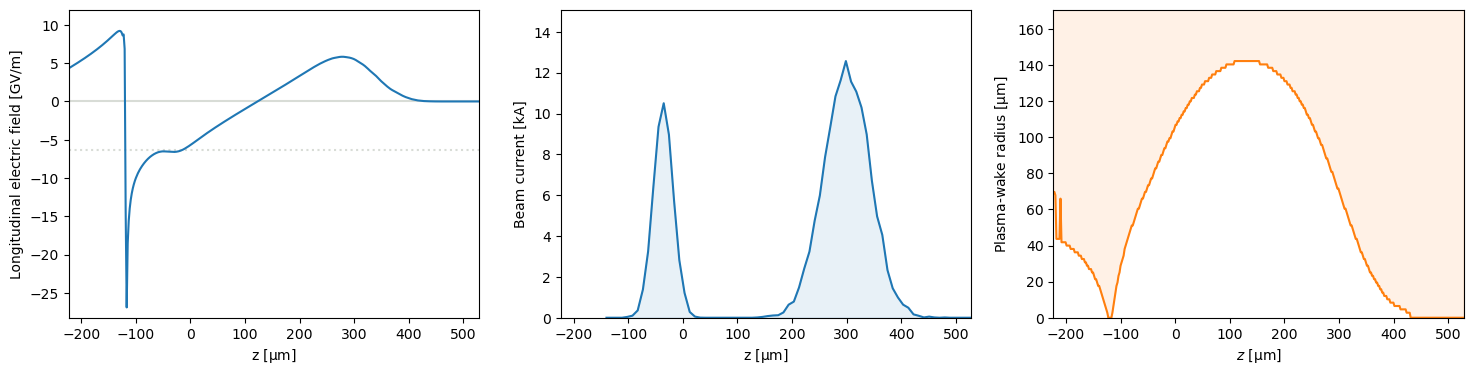

In [5]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

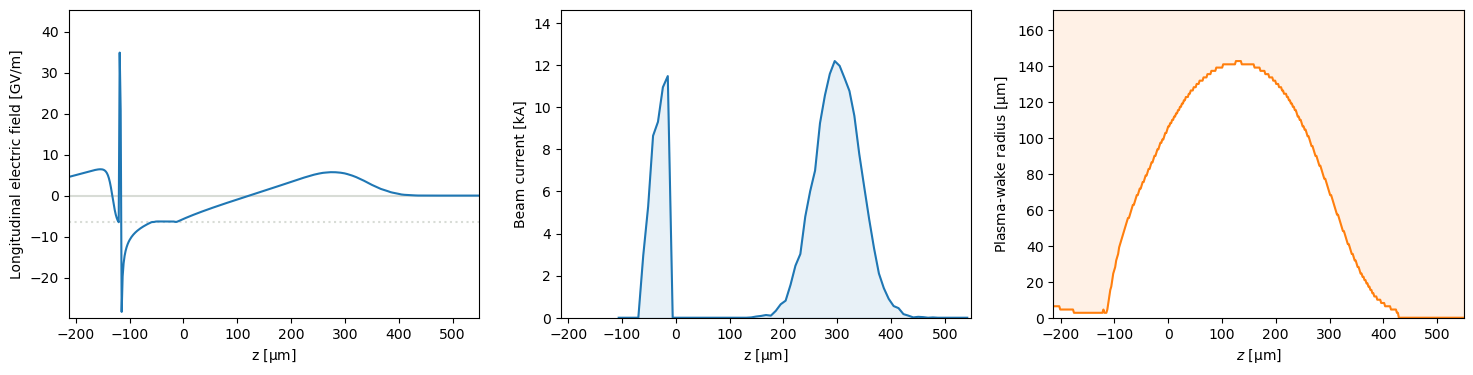

In [6]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

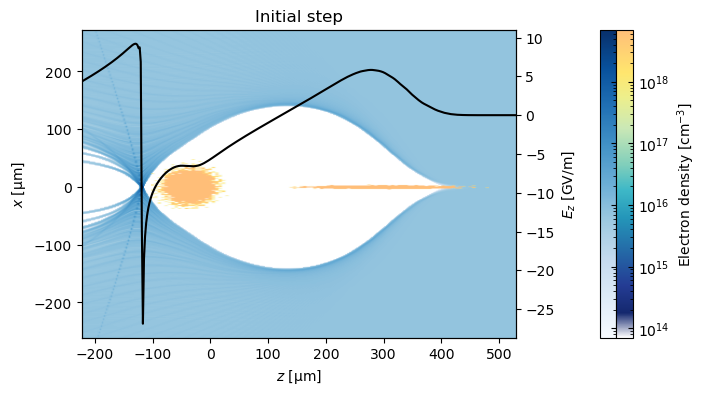

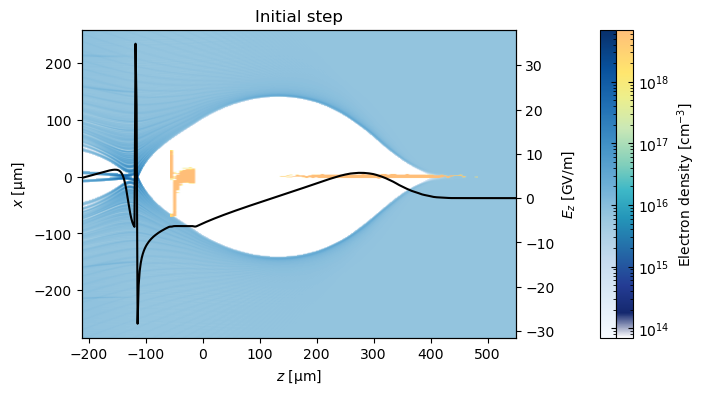

In [7]:
linac.stages[0].plot_wake()
plt.savefig(plot_path+'beams_wake_initial.png', format='png', dpi=300, bbox_inches='tight', transparent=False)
linac.stages[-1].plot_wake()
plt.savefig(plot_path+'beams_wake_final.png', format='png', dpi=300, bbox_inches='tight', transparent=False)

### Plot beam evolution and survey

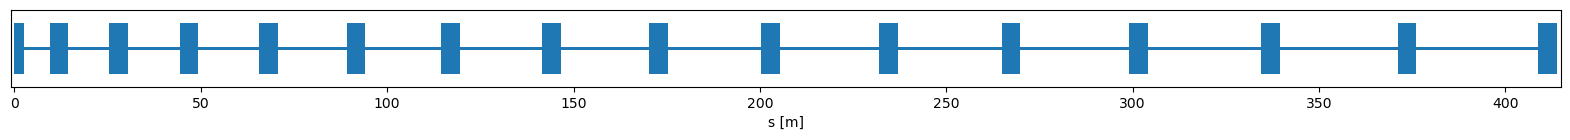

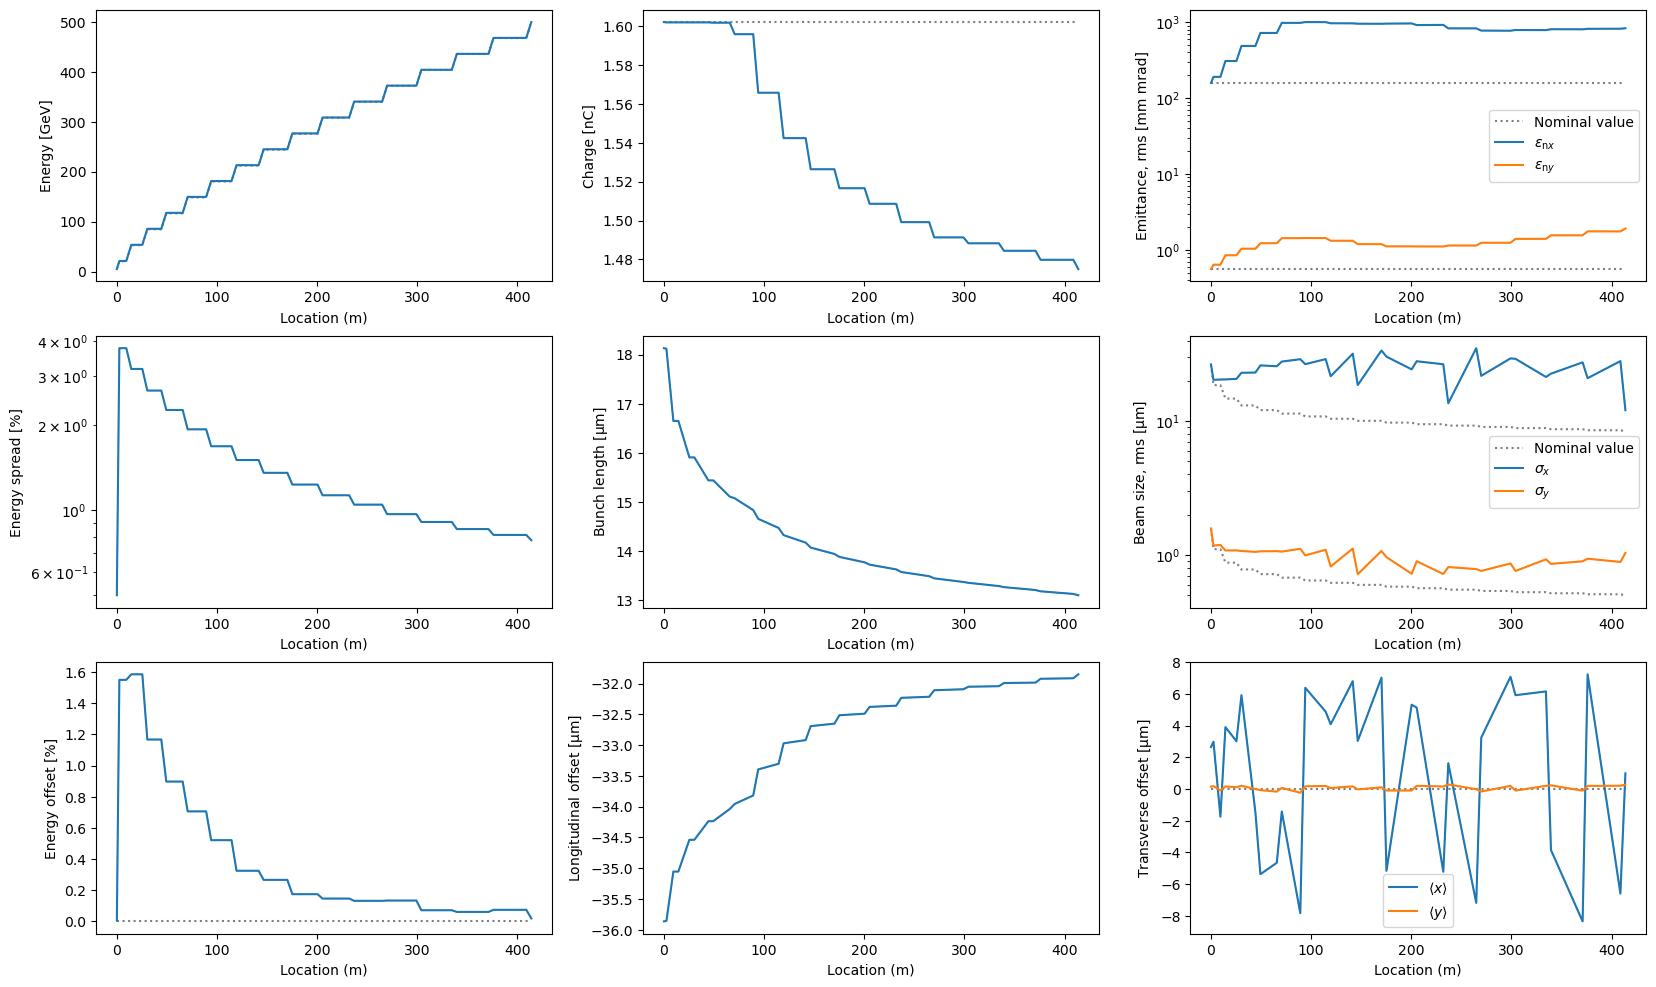

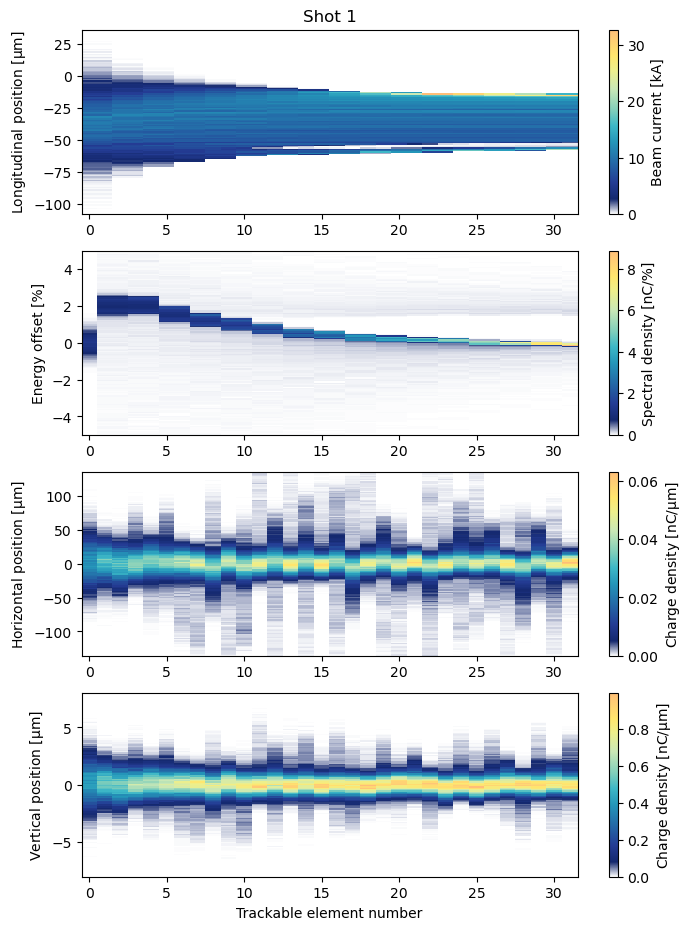

In [8]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution(use_stage_nums=False, save_fig=True)
linac[0].plot_waterfalls(save_fig=True)

In [9]:
linac.animate_sideview_x()
linac.animate_sideview_y()
linac.animate_phasespace_x()
linac.animate_phasespace_y()
linac.animate_lps()

'run_data/linac_example/plots/lps_shot0.gif'

![](run_data/linac_example/plots/lps_shot0.gif)

In [10]:
shot_num = 0
stage_num = 15
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [11]:
stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_out)

Time step [betatron wavelength/c]:		 0.050
Interstages enabled:				 False
Interstage dipole field:			 Not registered.
Ramp beta magnification:			 5.000
Radiation reaction enabled:			 False
Symmetrised drive beam:				 Not symmetrised.

Stage length [m]:				 5.000
Propagation length [m]:				 413.828
Drive beam to main beam efficiency [%]:		 35.179
Plasma density [m^-3]:				 7.000e+21
Drive beam x jitter (std) [um]:			 0.000
Drive beam y jitter (std) [um]:			 0.000
----------------------------------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Initial number of macroparticles:		 10000			 10000
Current number of macroparticles:		  			 9332
Initial beam population:			 2.700e+10 		 1.000e+10
Current beam population:			 	 		 9.332e+09

Weighted main beam gradient [GV/m]:			  		 -6.361395